In [1]:
import re
from dataclasses import dataclass
from typing import NamedTuple


@dataclass
class StateAction:
    write: int
    move: int
    next_: str

    def __call__(self, tape):
        tape.value = self.write
        tape.move(self.move)
        return self.next_


class State(NamedTuple):
    action_0: StateAction
    action_1: StateAction

    def __call__(self, tape):
        return self[tape.value](tape)
    
    @classmethod
    def from_iterable(cls, it):
        actions = []
        for current in (0, 1):
            assert f'If the current value is {current}:' in next(it)
            value = int(re.search(r'- Write the value (\d)\.', next(it)).group(1))
            move = -1 if 'left' in next(it) else 1
            next_ = re.search(r'- Continue with state ([A-Z])\.', next(it)).group(1)
            actions.append(StateAction(value, move, next_))
        return cls(*actions)


def read_states(lines):
    # find start
    it = iter(lines)
    states = {}
    starting_state = None
    diagnostic_checksum = 0
    parser = re.compile(
        r'('
        r'Begin in state (?P<start>[A-Z])\.'
        r'|'
        r'Perform a diagnostic checksum after (?P<checksum>\d+) steps\.'
        r'|'
        r'In state (?P<state>[A-Z]):'
        r')').search
    for match in filter(None, map(parser, it)):
        parsed = match.groupdict()
        if parsed['start']:
            starting_state = parsed['start']
        elif parsed['checksum']:
            diagnostic_checksum = int(parsed['checksum'])
        else:
            name = parsed['state']
            states[name] = State.from_iterable(it)
    for state in states.values():
        for action in state:
            action.next_ = states[action.next_]
    return states[starting_state], diagnostic_checksum


class Tape:
    def __init__(self):
        self._current = self._positive = [0]
        self._negative = []
        self._pos = 0

    @property
    def value(self):
        return self._current[abs(self._pos)]
    
    @value.setter
    def value(self, new_value):
        self._current[abs(self._pos)] = new_value
    
    def move(self, step):
        new_pos = self._pos + step
        if self._pos >= 0 and new_pos < 0:
            self._current = self._negative
        elif self._pos < 0 and new_pos >= 0:
            self._current = self._positive
        while len(self._current) <= abs(new_pos):
            # grow in batches, assume more will be needed on this end.
            self._current.extend([0] * 10)
        self._pos = new_pos
    
    def checksum(self):
        return sum(self._negative) + sum(self._positive)


def run_turing(state, checksum):
    tape = Tape()
    for _ in range(checksum):
        state = state(tape)
    return tape.checksum()

In [2]:
assert run_turing(*read_states('''\
Begin in state A.
Perform a diagnostic checksum after 6 steps.

In state A:
  If the current value is 0:
    - Write the value 1.
    - Move one slot to the right.
    - Continue with state B.
  If the current value is 1:
    - Write the value 0.
    - Move one slot to the left.
    - Continue with state B.

In state B:
  If the current value is 0:
    - Write the value 1.
    - Move one slot to the left.
    - Continue with state A.
  If the current value is 1:
    - Write the value 1.
    - Move one slot to the right.
    - Continue with state A.
'''.splitlines())) == 3

In [3]:
import aocd

data = aocd.get_data(day=25, year=2017)
start, checksum = read_states(data.splitlines())

In [4]:
print('Part 1:', run_turing(start, checksum))

Part 1: 4769


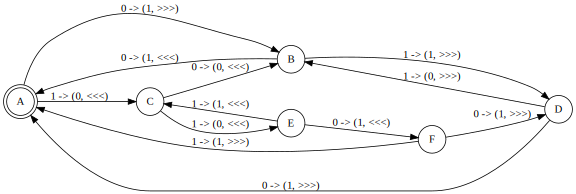

In [5]:
from graphviz import Digraph

dot = Digraph(comment='Turing state machine')
dot.attr(rankdir='LR', size='8,5')

blueprints = iter(data.splitlines())
start = re.search(r'Begin in state (?P<start>[A-Z])\.', next(blueprints)).group('start')
parser = re.compile(r'In state (?P<state>[A-Z]):').search
for match in filter(None, map(parser, blueprints)):
    name = match.group('state')
    state = State.from_iterable(blueprints)
    dot.node(name, shape='doublecircle' if name == start else 'circle')
    for edge in (0, 1):
        action = state[edge]
        move = '<<<' if action.move == -1 else '>>>'
        dot.edge(name, action.next_,
                 label=f'{edge} -> ({action.write}, {move})')

dot